In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from scipy.linalg import svd
from functions import *
from get_estimated_covariance import *
import scipy.stats
from scipy.interpolate import UnivariateSpline
%matplotlib inline
%load_ext autoreload
%autoreload 2

n = 500
t = np.linspace(0,1,n+1)
ma = np.meshgrid(t,t)
#bla = np.exp(-(ma[0]-ma[1])**2/0.01)
A = np.minimum(ma[0],ma[1])
A = A[1:,1:]
plt.imshow(A)

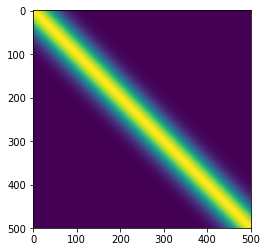

In [5]:
n = 500
t = np.linspace(0,1,n)
ma = np.meshgrid(t,t)
A = np.exp(-(ma[0]-ma[1])**2/0.01)
plt.imshow(A)

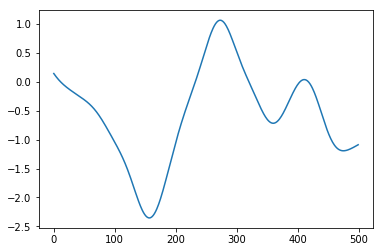

In [20]:
x = np.random.multivariate_normal(np.zeros(n), A)
plt.plot(x)

In [21]:
eigv, eigf = np.linalg.eigh(A)

In [22]:
np.linalg.matrix_rank(A)

41

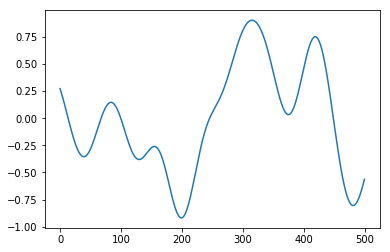

In [23]:
r = 20
rA = eigf[:,-r:] @ np.diag(eigv[-r:]) @ eigf[:,-r:].T
sqrtrA = eigf[:,-r:] @ np.diag(np.sqrt(eigv[-r:])) @ eigf[:,-r:].T
plt.plot(np.random.multivariate_normal(np.zeros(n), rA))

noise = (np.random.normal(0,1,n)/np.arange(500,500+n))**2
noisyrA = rA + eigf @ np.diag(noise) @ eigf.T
plt.plot(np.random.multivariate_normal(np.zeros(n), noisyrA))

/home/william/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:4: RuntimeWarning: invalid value encountered in sqrt


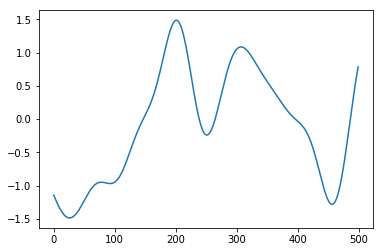

In [29]:
newdiag = np.copy(eigv)
newdiag[:-r] /= 1000
noisyrA = eigf @ np.diag(newdiag) @ eigf.T
noisysqrtrA = eigf @ np.diag(np.sqrt(newdiag)) @ eigf.T
plt.plot(np.random.multivariate_normal(np.zeros(n), noisyrA))

In [30]:
np.linalg.matrix_rank(rA),np.linalg.matrix_rank(noisyrA)

(20, 35)

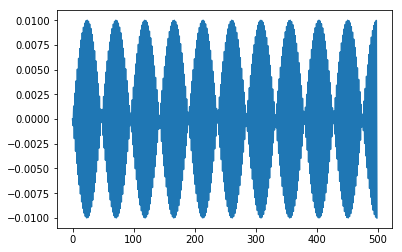

In [31]:
ormu = noisyrA @ eigf[:,-21] * 1e6
t = np.linspace(0,1,n)
ormu = np.sin((510-0.5)*np.pi*t) * 1e-2
plt.plot(ormu)

In [32]:
np.linalg.norm(ormu),np.linalg.norm(np.linalg.solve(noisyrA,ormu))

(0.15811388300841694, 6493998663788944.0)

In [619]:
def genrv(scov,N):
    x = np.random.multivariate_normal(np.zeros(n),np.eye(n),N)
    return x @ scov 

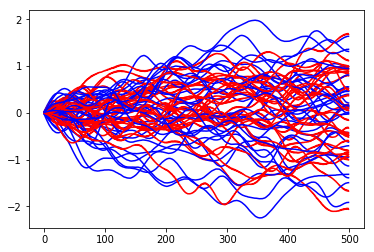

In [620]:
for i in range(30):
    plt.plot(genrv(noisysqrtrA,1)[0]+ormu,'r') 
    plt.plot(genrv(noisysqrtrA,1)[0],'b')

In [621]:
N = 5000
data1 = genrv(scipy.linalg.sqrtm(A),N)
data2 = genrv(scipy.linalg.sqrtm(A),N) + ormu

In [622]:
alpha = 1e-5
regrA = rA + alpha * np.eye(n)

In [623]:
disc = np.linalg.solve(A,ormu)

In [624]:
def disctest(x,mu):
    return (disc @ x)**2 - (disc @ (x-mu))**2

In [625]:
res = np.zeros((N,2))
for _ in range(N):
    res[_] = np.array([disctest(data1[_],ormu),disctest(data2[_],ormu)])

{'boxes': [<matplotlib.lines.Line2D at 0x7f2a3666cd68>,
 'caps': [<matplotlib.lines.Line2D at 0x7f2a366718d0>,
 'fliers': [<matplotlib.lines.Line2D at 0x7f2a36678630>,
 'means': [],
 'medians': [<matplotlib.lines.Line2D at 0x7f2a366781d0>,
 'whiskers': [<matplotlib.lines.Line2D at 0x7f2a3666cef0>,
  <matplotlib.lines.Line2D at 0x7f2a3667c390>]}

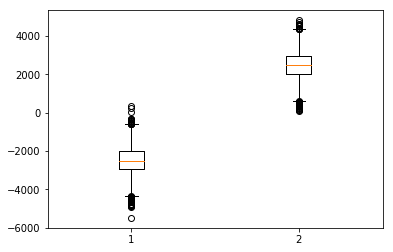

In [626]:
plt.boxplot(res)

In [627]:
np.mean(res[:,0]<0),np.mean(res[:,1]>0)

(0.99939999999999996, 1.0)

In [633]:
dt = 200
discfrags = np.zeros((n-dt,dt))
for i in range(n-dt):
    cov = A[i:i+dt,i:i+dt]
    discfrags[i] = np.linalg.solve(cov,ormu[i:i+dt])

In [634]:
def disctestfrag(x,mu,i):
    return (discfrags[i]@ x)**2 - (discfrags[i] @ (x-mu))**2

In [635]:
res = np.zeros((N*(n-dt),2))
for _ in range(N):
    for i in range(n-dt):
        res[_*(n-dt) + i] = np.array([disctestfrag(data1[_,i:i+dt],ormu[i:i+dt],i),disctestfrag(data2[_,i:i+dt],ormu[i:i+dt],i)])

{'boxes': [<matplotlib.lines.Line2D at 0x7f2a36587898>,
 'caps': [<matplotlib.lines.Line2D at 0x7f2a3658d400>,
 'fliers': [<matplotlib.lines.Line2D at 0x7f2a36592160>,
 'means': [],
 'medians': [<matplotlib.lines.Line2D at 0x7f2a3658dcc0>,
 'whiskers': [<matplotlib.lines.Line2D at 0x7f2a36587a20>,
  <matplotlib.lines.Line2D at 0x7f2a36592e80>]}

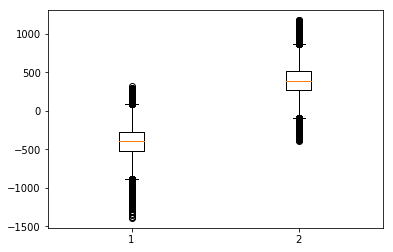

In [636]:
plt.boxplot(res)

In [637]:
np.mean(res[:,0]<0),np.mean(res[:,1]>0)

(0.98580933333333332, 0.985954)

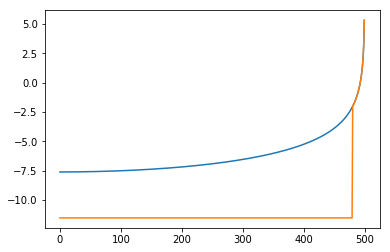

In [535]:
plt.plot(np.log(np.linalg.eigvalsh(A)))
plt.plot(np.log(np.linalg.eigvalsh(regrA)))

In [384]:
N = 5000
data1 = genrv(scipy.linalg.sqrtm(A),N)
data2 = genrv(scipy.linalg.sqrtm(A),N) + ormu

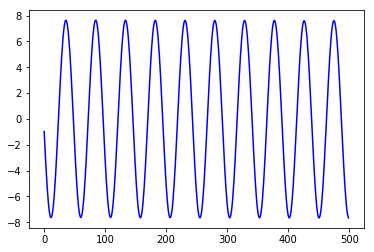

In [385]:
mu1 = data1.mean(0)
mu2 = data2.mean(0)
estmu = mu2-mu1
plt.plot(estmu,'b')

In [386]:
estmu = ormu

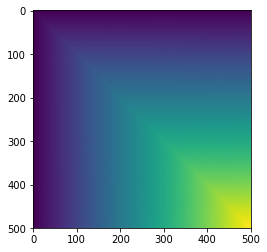

In [415]:
estcov = np.cov(np.r_[data1,data2-estmu], rowvar=False)
plt.imshow(estcov)

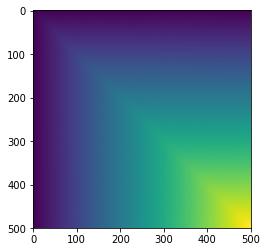

In [416]:
alpha = 0
regestcov = estcov + alpha * np.eye(n)
esteig = np.linalg.eigh(estcov)[1][:,-r:]
regestcov = esteig @ np.linalg.pinv(esteig.T @ esteig) @ esteig.T @ estcov
plt.imshow(regestcov)

In [417]:
disc = np.linalg.solve(regestcov,estmu)

In [418]:
def disctest(x,mu):
    return (disc @ x)**2 - (disc @ (x-mu))**2

In [419]:
res = np.zeros((N,2))
for _ in range(N):
    res[_] = np.array([disctest(data1[_],estmu),disctest(data2[_],estmu)])

{'boxes': [<matplotlib.lines.Line2D at 0x7f2a374c2358>,
 'caps': [<matplotlib.lines.Line2D at 0x7f2a374c2e80>,
 'fliers': [<matplotlib.lines.Line2D at 0x7f2a374c9be0>,
 'means': [],
 'medians': [<matplotlib.lines.Line2D at 0x7f2a374c9780>,
 'whiskers': [<matplotlib.lines.Line2D at 0x7f2a374c24e0>,
  <matplotlib.lines.Line2D at 0x7f2a374ce940>]}

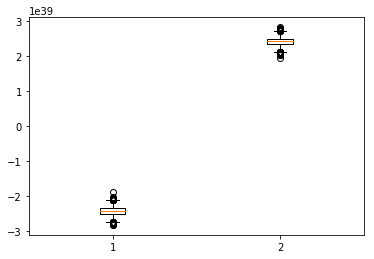

In [420]:
plt.boxplot(res)

In [421]:
np.mean(res[:,0]<0),np.mean(res[:,1]>0)

(1.0, 1.0)

In [438]:
dt = 20
discfrags = np.zeros((n-dt,dt))
for i in range(n-dt):
    cov = regestcov[i:i+dt,i:i+dt]
    discfrags[i] = np.linalg.solve(cov,estmu[i:i+dt])

In [439]:
def disctestfrag(x,mu,i):
    return (discfrags[i]@ x)**2 - (discfrags[i] @ (x-mu))**2

In [440]:
res = np.zeros((N*(n-dt),2))
for _ in range(N):
    for i in range(n-dt):
        res[_*(n-dt) + i] = np.array([disctestfrag(data1[_,i:i+dt],estmu[i:i+dt],i),disctestfrag(data2[_,i:i+dt],estmu[i:i+dt],i)])

{'boxes': [<matplotlib.lines.Line2D at 0x7f2a373ea780>,
 'caps': [<matplotlib.lines.Line2D at 0x7f2a373f12e8>,
 'fliers': [<matplotlib.lines.Line2D at 0x7f2a373f6048>,
 'means': [],
 'medians': [<matplotlib.lines.Line2D at 0x7f2a373f1ba8>,
 'whiskers': [<matplotlib.lines.Line2D at 0x7f2a373ea908>,
  <matplotlib.lines.Line2D at 0x7f2a373f6d68>]}

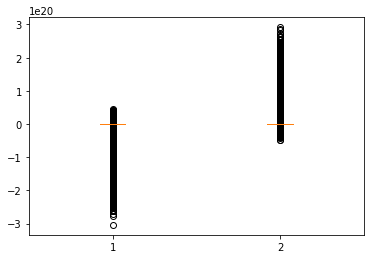

In [441]:
plt.boxplot(res)

In [442]:
np.mean(res[:,0]<0),np.mean(res[:,1]>0)

(0.87533208333333334, 0.87538583333333331)

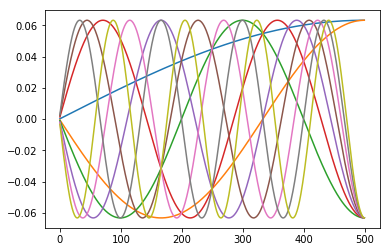

In [453]:
for _ in range(1,10):
    plt.plot(eigf[:,-_])

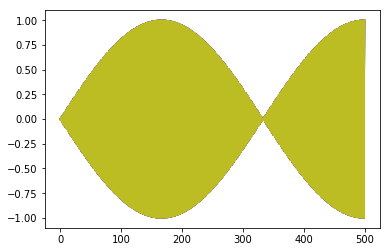

In [456]:
for _ in range(1,10):
    t = np.linspace(0,1,n)
    plt.plot(np.sin((501-0.5)*np.pi*t))

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from scipy.linalg import svd
from functions import *
from get_estimated_covariance import *
import scipy.stats
from scipy.interpolate import UnivariateSpline
%matplotlib inline
%load_ext autoreload
%autoreload 2

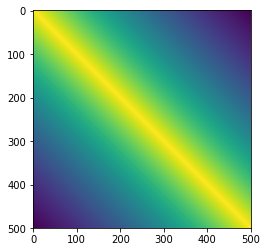

In [623]:
n = 500
t = np.linspace(0,1,n)
ma = np.meshgrid(t,t)
A = np.exp(-np.abs(ma[0]-ma[1])) 
plt.imshow(A)

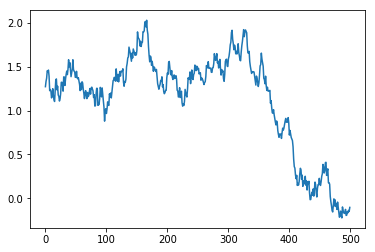

In [624]:
x = np.random.multivariate_normal(np.zeros(n), A)
plt.plot(x)

In [625]:
eigv, eigf = np.linalg.eigh(A)

In [626]:
np.linalg.matrix_rank(A)

500

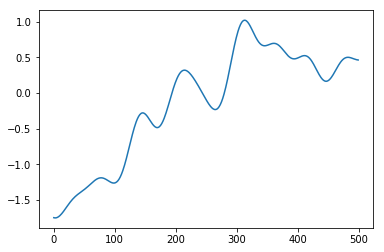

In [627]:
r = 20
rA = eigf[:,-r:] @ np.diag(eigv[-r:]) @ eigf[:,-r:].T
sqrtrA = eigf[:,-r:] @ np.diag(np.sqrt(eigv[-r:])) @ eigf[:,-r:].T
plt.plot(np.random.multivariate_normal(np.zeros(n), rA))

In [628]:
np.linalg.matrix_rank(rA)

20

In [629]:
mu = 10 * np.ones(500)/np.sqrt(500)

In [630]:
np.linalg.matrix_rank(np.c_[rA,mu])

21

In [631]:
np.linalg.norm(np.linalg.solve(rA,mu))

157272117394891.03

In [632]:
N = 1000
data1 = np.random.multivariate_normal(np.zeros(500),rA,N)
data2 = np.random.multivariate_normal(mu,rA,N)

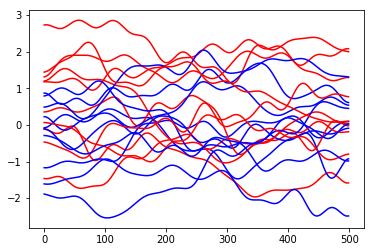

In [633]:
for i in range(10):
    plt.plot(data1[i],'b')
    plt.plot(data2[i],'r')

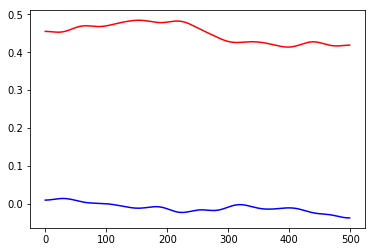

In [634]:
plt.plot(data1.mean(0),'b')
plt.plot(data2.mean(0),'r')

In [635]:
disc = np.linalg.solve(rA,mu)

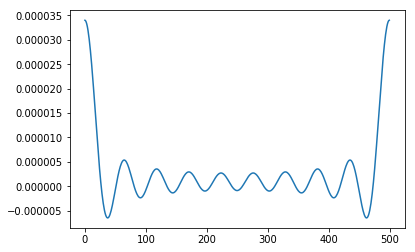

In [636]:
blaeigv = np.linalg.eigh(rA)[0]
blaeigf = np.linalg.eigh(rA)[1]

disc = np.zeros(500)
for i in range(1,r+1):
    disc += np.sum(blaeigf[:,-i]*mu)/500 * (1/blaeigv[-i]) *blaeigf[:,-i] 

plt.plot(disc)

In [637]:
def disctest(x,mu):
    return (disc @ x)**2 - (disc @ (x-mu))**2

In [638]:
res = np.zeros((N,2))
for _ in range(N):
    res[_] = np.array([disctest(data1[_],mu),disctest(data2[_],mu)])

{'boxes': [<matplotlib.lines.Line2D at 0x7f682ad22c88>,
 'caps': [<matplotlib.lines.Line2D at 0x7f682a56f4a8>,
 'fliers': [<matplotlib.lines.Line2D at 0x7f682ad03ef0>,
 'means': [],
 'medians': [<matplotlib.lines.Line2D at 0x7f682a56fb70>,
 'whiskers': [<matplotlib.lines.Line2D at 0x7f682ad22e80>,
  <matplotlib.lines.Line2D at 0x7f682a875ef0>]}

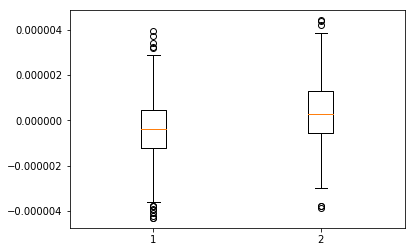

In [639]:
plt.boxplot(res)

In [640]:
np.mean(res[:,0]<0),np.mean(res[:,1]>0)

(0.60999999999999999, 0.58499999999999996)

In [641]:
dt = 300
discfrags = np.zeros((n-dt,dt))
for i in range(n-dt):
    cov = rA[i:i+dt,i:i+dt]
    discfrags[i] = np.linalg.solve(cov,mu[i:i+dt])

In [642]:
np.linalg.matrix_rank(rA[:300,:300])

17

In [643]:
dt = 400
discfrags = np.zeros((n-dt,dt))
for i in range(n-dt):
    cov = rA[i:i+dt,i:i+dt]
    theeig = np.linalg.eigh(cov)
    blaeigv = theeig[0]
    blaeigf = theeig[1]

    for j in range(1,np.linalg.matrix_rank(cov)+1):
        discfrags[i] += np.sum(blaeigf[:,-j]*mu[i:i+dt])/dt * (1/blaeigv[-j]) *blaeigf[:,-j] 

In [644]:
def disctestfrag(x,mu,i):
    return (discfrags[i]@ x)**2 - (discfrags[i] @ (x-mu))**2

In [645]:
res = np.zeros((N*(n-dt),2))
for _ in range(N):
    for i in range(n-dt):
        res[_*(n-dt) + i] = np.array([disctestfrag(data1[_,i:i+dt],mu[i:i+dt],i),disctestfrag(data2[_,i:i+dt],mu[i:i+dt],i)])

{'boxes': [<matplotlib.lines.Line2D at 0x7f682b026cf8>,
 'caps': [<matplotlib.lines.Line2D at 0x7f682ab52b38>,
 'fliers': [<matplotlib.lines.Line2D at 0x7f682b032710>,
 'means': [],
 'medians': [<matplotlib.lines.Line2D at 0x7f682b032278>,
 'whiskers': [<matplotlib.lines.Line2D at 0x7f682b026320>,
  <matplotlib.lines.Line2D at 0x7f682ae0a160>]}

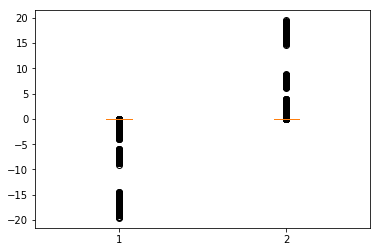

In [646]:
plt.boxplot(res)

In [561]:
np.mean(res[:,0]<0),np.mean(res[:,1]>0)

(0.83245000000000002, 0.81330999999999998)

In [562]:
np.mean([np.mean(res[:,0]<0),np.mean(res[:,1]>0)])

0.82288000000000006

In [499]:
np.max(res[:,0]), np.min(res[:,1])

(0.0013109306182818657, -0.0012828425618026246)

In [493]:
np.linalg.cond(rA)

6.2925714799226094e+19

In [384]:
np.linalg.cond(rA[0:300,0:300])

1.6060640674277896e+19

In [ ]:
wesh = []
for dt in range(10,500,10):
    for maxrank in range(1,21):
        data1 = np.random.multivariate_normal(np.zeros(500),rA,N)
        data2 = np.random.multivariate_normal(mu,rA,N)
        discfrags = np.zeros((n-dt,dt))
        for i in range(n-dt):
            cov = rA[i:i+dt,i:i+dt]
            theeig = np.linalg.eigh(cov)
            blaeigv = theeig[0]
            blaeigf = theeig[1]

            #for j in range(1,np.linalg.matrix_rank(cov)+1):
            for j in range(1,min(maxrank,dt)+1):
                discfrags[i] += np.sum(blaeigf[:,-j]*mu[i:i+dt])/dt * (1/blaeigv[-j]) *blaeigf[:,-j] 

        def disctestfrag(x,mu,i):
            return (discfrags[i]@ x)**2 - (discfrags[i] @ (x-mu))**2

        res = np.zeros((N*(n-dt),2))
        for _ in range(N):
            for i in range(n-dt):
                res[_*(n-dt) + i] = np.array([disctestfrag(data1[_,i:i+dt],mu[i:i+dt],i),disctestfrag(data2[_,i:i+dt],mu[i:i+dt],i)])

        plt.boxplot(res)

        np.mean(res[:,0]<0),np.mean(res[:,1]>0)
        wesh.append(np.mean([np.mean(res[:,0]<0),np.mean(res[:,1]>0)]))
        print(maxrank,dt,np.mean([np.mean(res[:,0]<0),np.mean(res[:,1]>0)]))

1 10 0.589389795918
2 10 0.580116326531
3 10 0.581945918367
4 10 0.608984693878
5 10 0.620601020408
6 10 0.619758163265
7 10 0.605723469388
8 10 0.576582653061
9 10 0.551107142857
10 10 0.553581632653
11 10 0.553671428571


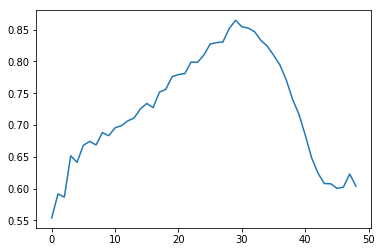

In [649]:
plt.plot(wesh)